## CONCEPT PROBE SCORES

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import os

In [15]:
APPROACHES = [
        "random_policy_play",
        "model_of_interest_greedy_play",
        "model_of_interest_epsilon0_005_play",
        "more_capable_model_greedy_play",
        "more_capable_model_epsilon0_005_play",
    ]

def get_approach_cps_df_for_envs(env_name: str, model_name: str):
    cps_dfs = {}
    for approach in APPROACHES:
        df = pd.read_csv(f"../../rl_tcav_data/cavs/baseline_concept_probes_experiment/{env_name}/{model_name}/{approach}/concept_probe_scores_{approach}.csv")
        cps_dfs[approach] = df
    return cps_dfs


In [16]:
gc_cps_dfs = get_approach_cps_df_for_envs("gem_collector", "model_denim-sweep-56")
mc_cps_dfs = get_approach_cps_df_for_envs("minecart_counter", "model_kind-cosmos-35")
grm_cps_dfs = get_approach_cps_df_for_envs("gold_run_mini", "model_firm-mountain-13")


In [17]:
# Filtering out uncommon sample sizes and the last layer

def is_valid_sample_size(sample_size):
    if sample_size % 10 != 0:  
        return False
    power_check = sample_size // 10
    return (power_check & (power_check - 1)) == 0  

def filter_valid_sample_sizes_and_layers(cps_dfs):
    filtered_cps_dfs = {}
    for approach, df in cps_dfs.items():
        df_filtered = df[df["sample_size"].apply(is_valid_sample_size)] 
        df_filtered = df_filtered[df_filtered["layer_index"] != 6] 
        filtered_cps_dfs[approach] = df_filtered
    return filtered_cps_dfs

gc_cps_dfs = filter_valid_sample_sizes_and_layers(gc_cps_dfs)
mc_cps_dfs = filter_valid_sample_sizes_and_layers(mc_cps_dfs)
grm_cps_dfs = filter_valid_sample_sizes_and_layers(grm_cps_dfs)

In [18]:
for appr, df in gc_cps_dfs.items():
    print(f"Max sample size for {appr}: {df['sample_size'].max()}")

Max sample size for random_policy_play: 81920
Max sample size for model_of_interest_greedy_play: 40960
Max sample size for model_of_interest_epsilon0_005_play: 40960
Max sample size for more_capable_model_greedy_play: 81920
Max sample size for more_capable_model_epsilon0_005_play: 81920


In [19]:
for appr, df in mc_cps_dfs.items():
    print(f"Max sample size for {appr}: {df['sample_size'].max()}")

Max sample size for random_policy_play: 20480
Max sample size for model_of_interest_greedy_play: 5120
Max sample size for model_of_interest_epsilon0_005_play: 10240
Max sample size for more_capable_model_greedy_play: 40960
Max sample size for more_capable_model_epsilon0_005_play: 40960


In [21]:
for appr, df in grm_cps_dfs.items():
    print(f"Max sample size for {appr}: {df['sample_size'].max()}")

Max sample size for random_policy_play: 1280
Max sample size for model_of_interest_greedy_play: 1280
Max sample size for model_of_interest_epsilon0_005_play: 1280
Max sample size for more_capable_model_greedy_play: 2560
Max sample size for more_capable_model_epsilon0_005_play: 5120


### How many examples? What approach? Effect of concept probe scores on validation sets with increased sample size, for all approaches

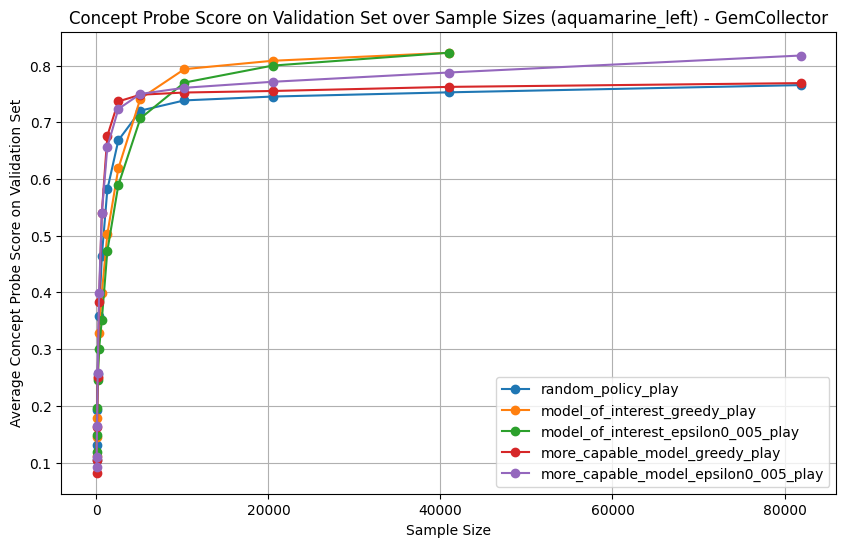

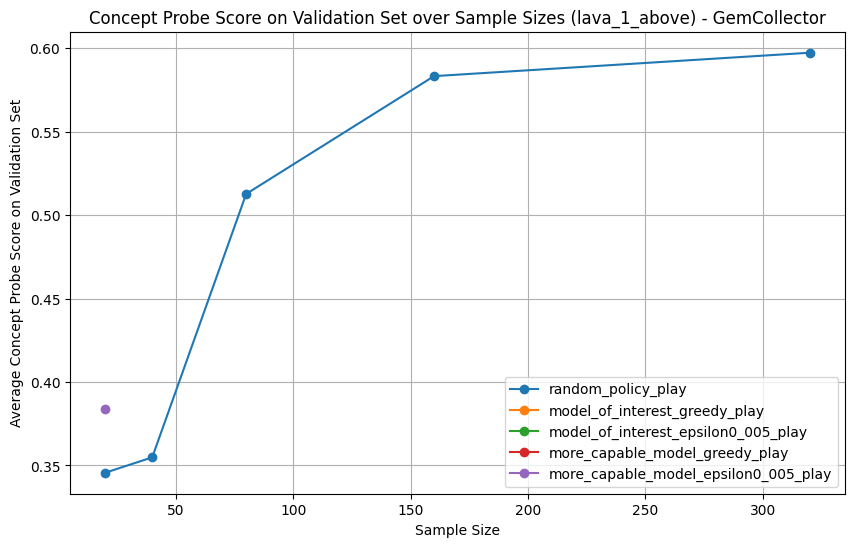

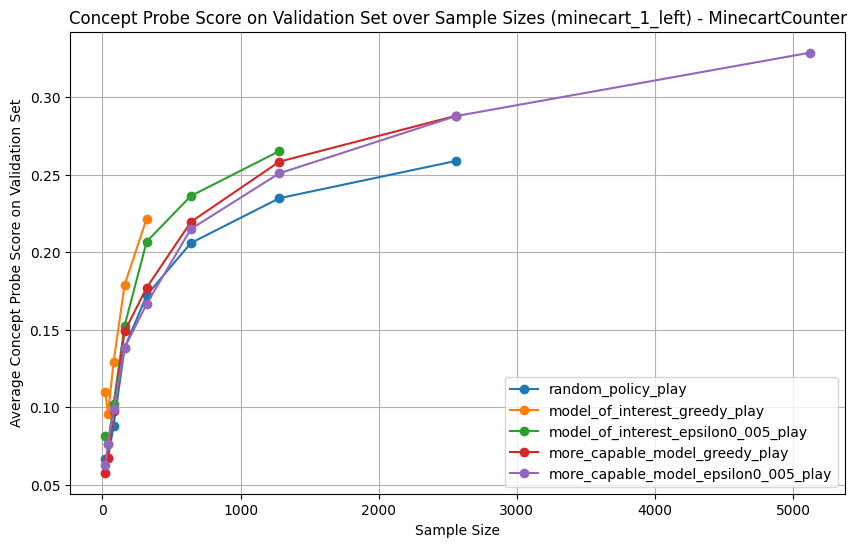

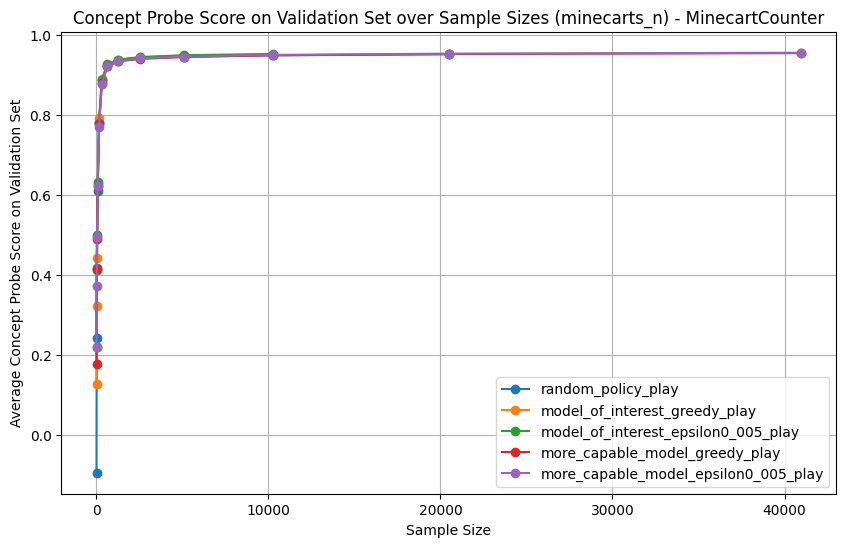

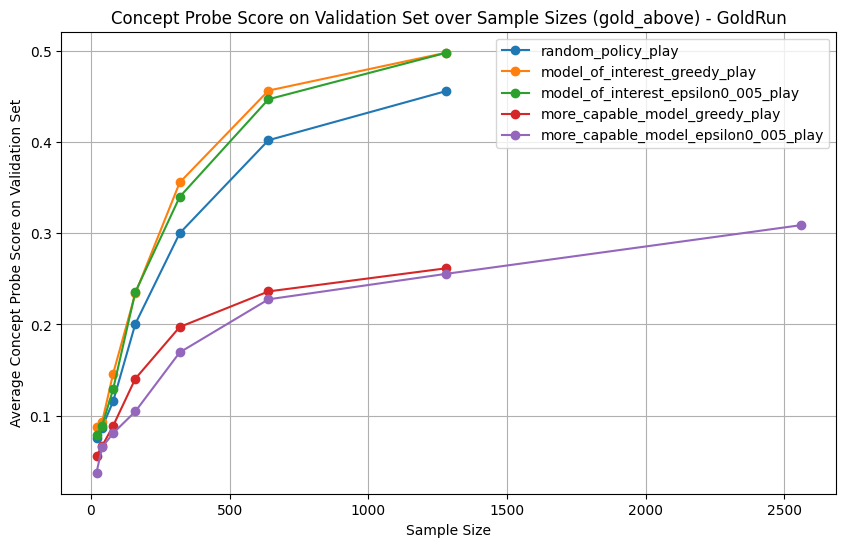

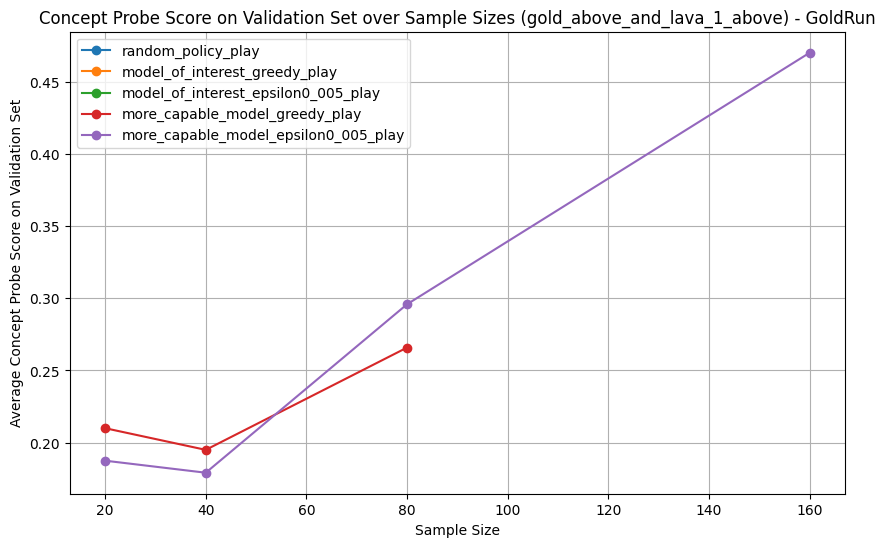

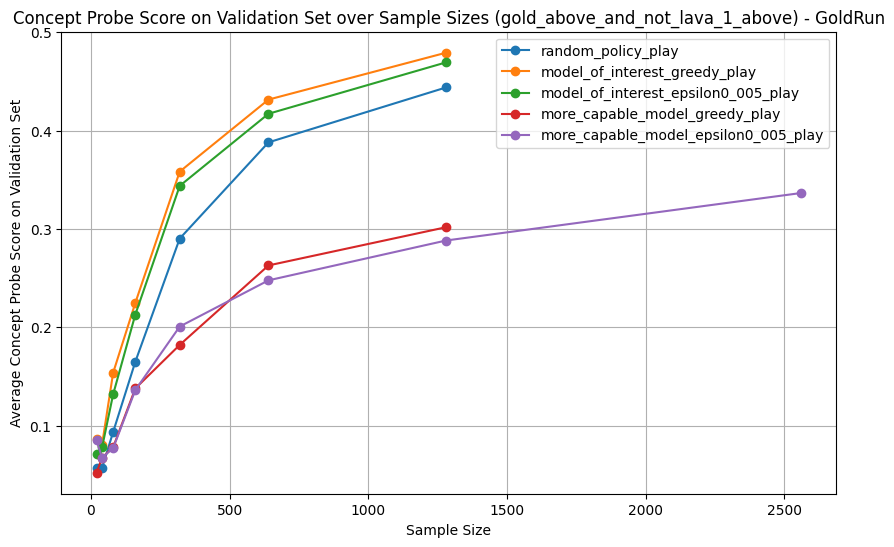

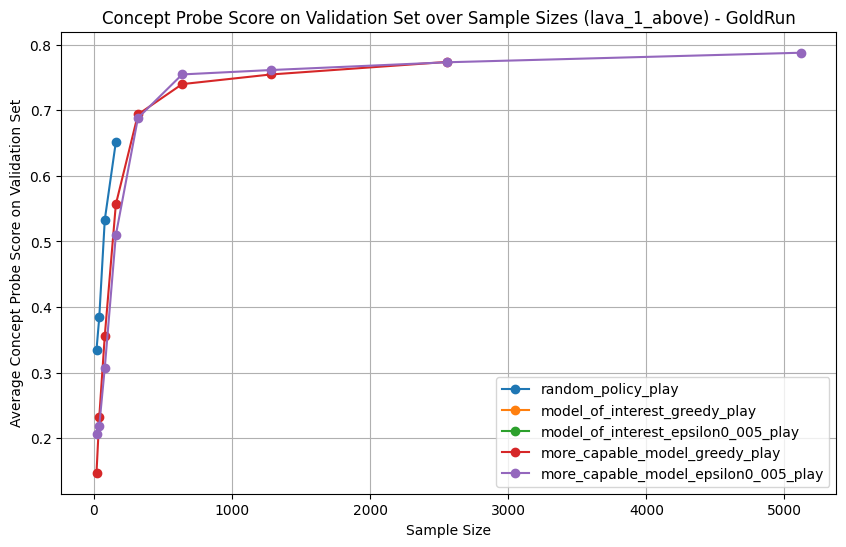

In [23]:

def plot_concept_probe_scores_on_val_set_per_approach(cps_dfs, env_name, use_log=False):
    """
    Generate plots of concept probe scores for each unique concept in the dataset.

    Parameters
    ----------
    cps_dfs : dict
        A dictionary where keys are approach names and values are DataFrames containing concept probe scores.
    env_name : str
        The name of the environment (used for plot titles and saving figures).
    """
    for approach, df in cps_dfs.items():
        df["sample_size"] = df["sample_size"].astype(int)
        
    unique_concepts = set()
    for df in cps_dfs.values():
        unique_concepts.update(df["concept_name"].unique())

    for concept in unique_concepts:
        plt.figure(figsize=(10, 6))

        for approach, df in cps_dfs.items():
            concept_df = df[df["concept_name"] == concept]

            mean_scores = (
                concept_df.groupby("sample_size")["concept_probe_score_on_validation_set"]
                .mean()
                .reset_index()
            )

            plt.plot(
                mean_scores["sample_size"],
                mean_scores["concept_probe_score_on_validation_set"],
                marker="o",
                linestyle="-",
                label=approach
            )

        plt.xlabel("Sample Size")
        plt.ylabel("Average Concept Probe Score on Validation Set")
        plt.title(f"Concept Probe Score on Validation Set over Sample Sizes ({concept}) - {env_name}")
        plt.legend()
        plt.grid(True)
        if use_log:
            plt.xscale("log")  
        

        plt.show()

plot_concept_probe_scores_on_val_set_per_approach(gc_cps_dfs, "GemCollector")
plot_concept_probe_scores_on_val_set_per_approach(mc_cps_dfs, "MinecartCounter")
plot_concept_probe_scores_on_val_set_per_approach(grm_cps_dfs, "GoldRun")


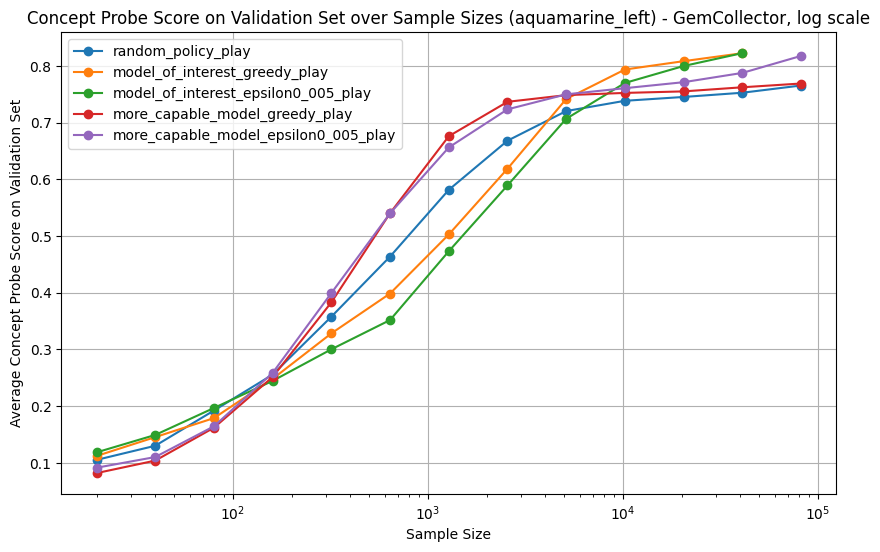

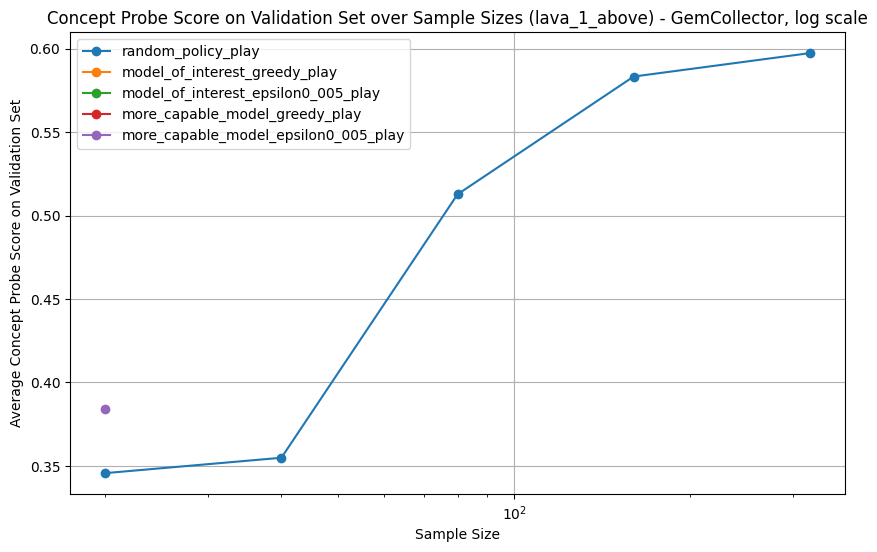

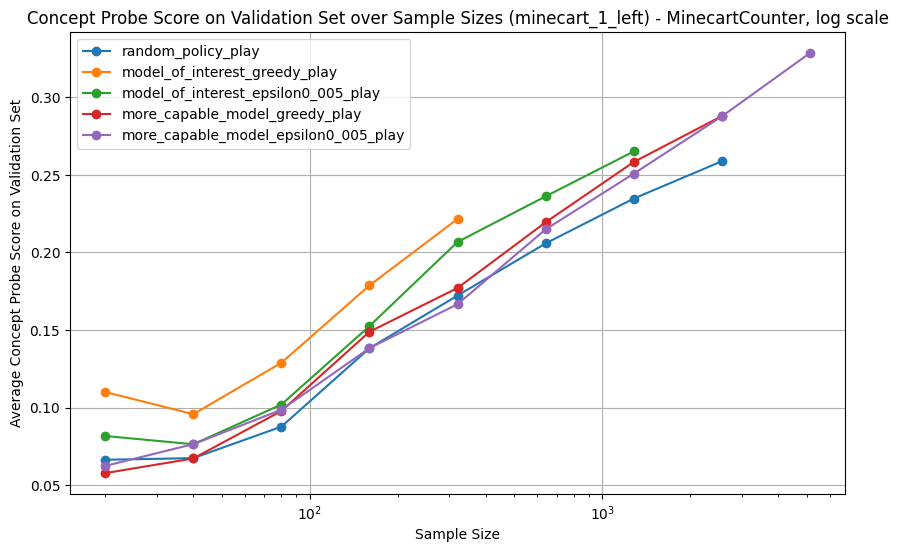

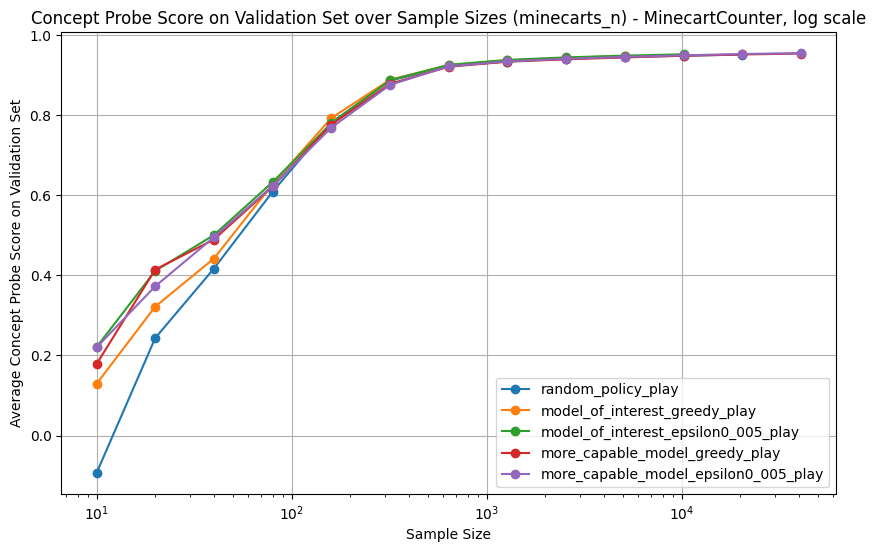

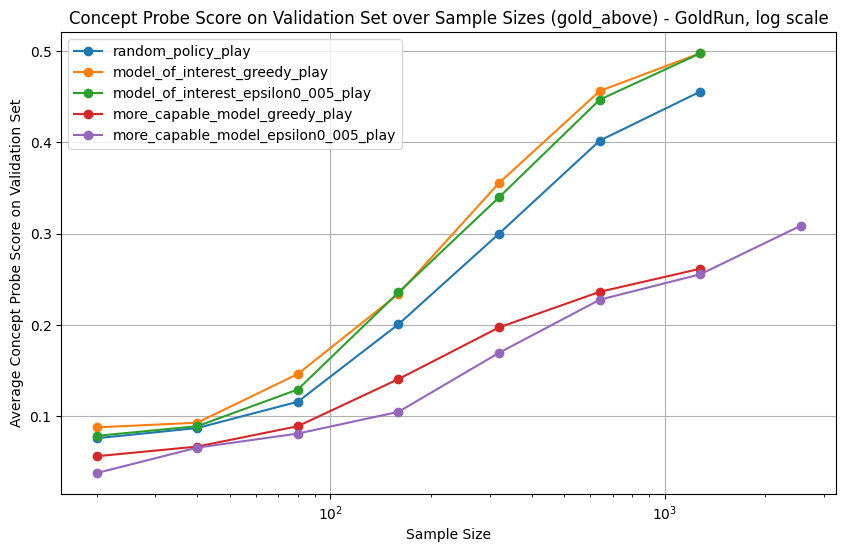

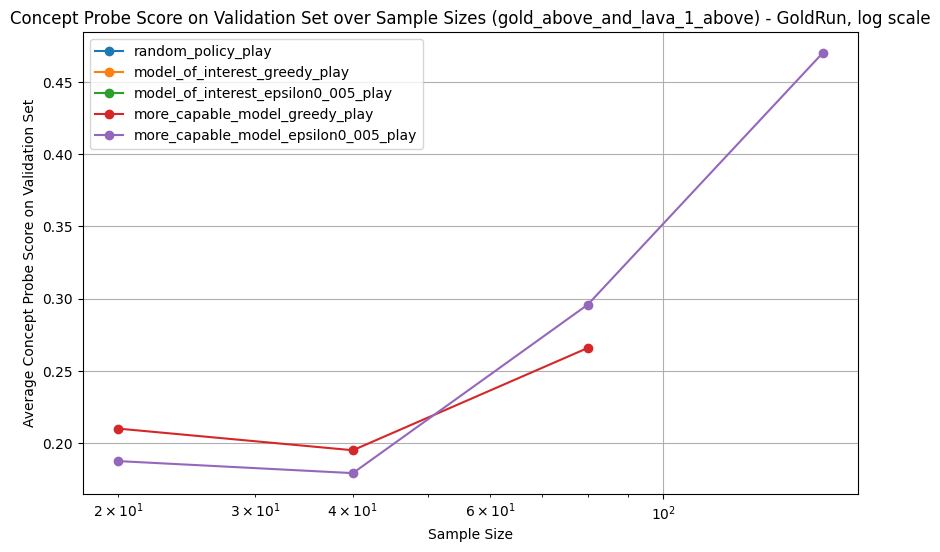

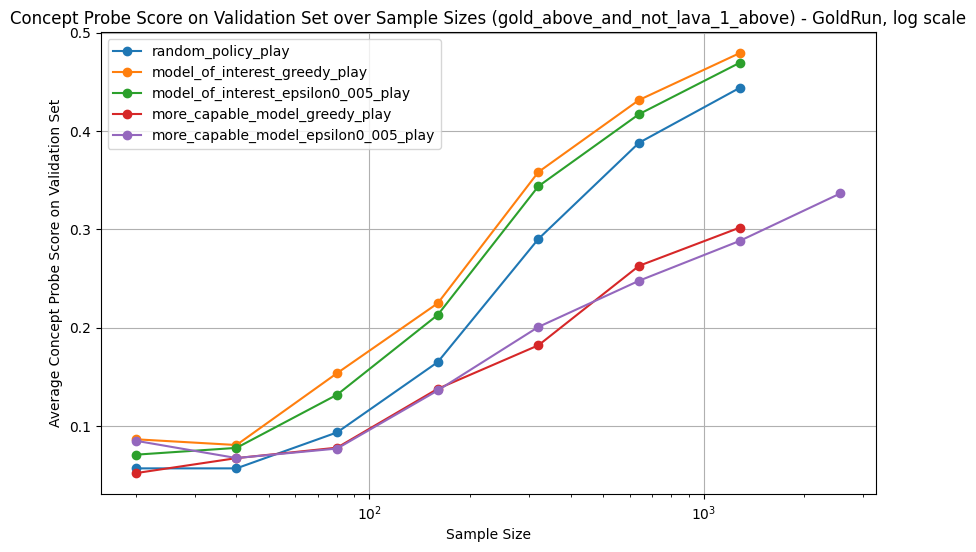

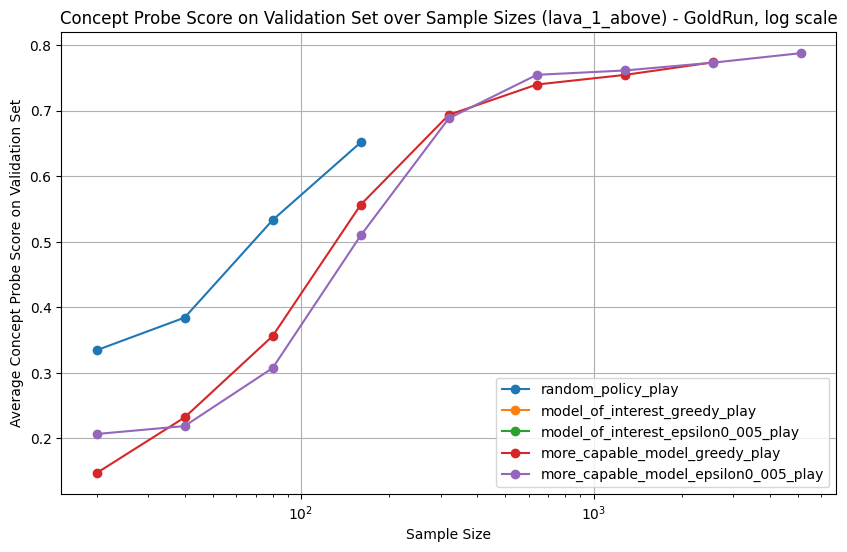

In [24]:
plot_concept_probe_scores_on_val_set_per_approach(gc_cps_dfs, "GemCollector, log scale", use_log=True)
plot_concept_probe_scores_on_val_set_per_approach(mc_cps_dfs, "MinecartCounter, log scale", use_log=True)
plot_concept_probe_scores_on_val_set_per_approach(grm_cps_dfs, "GoldRun, log scale", use_log=True)

### In what layer? The effect of increased sample size for concept probe score on validation set for each layer

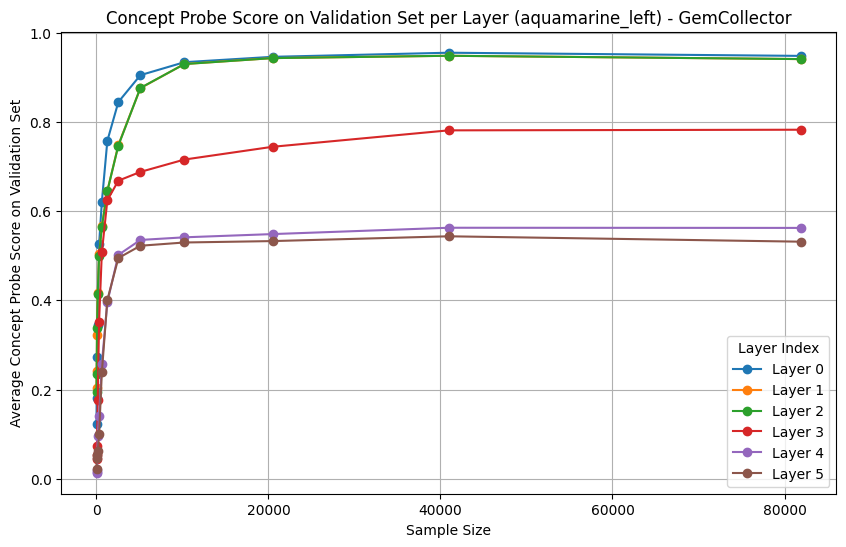

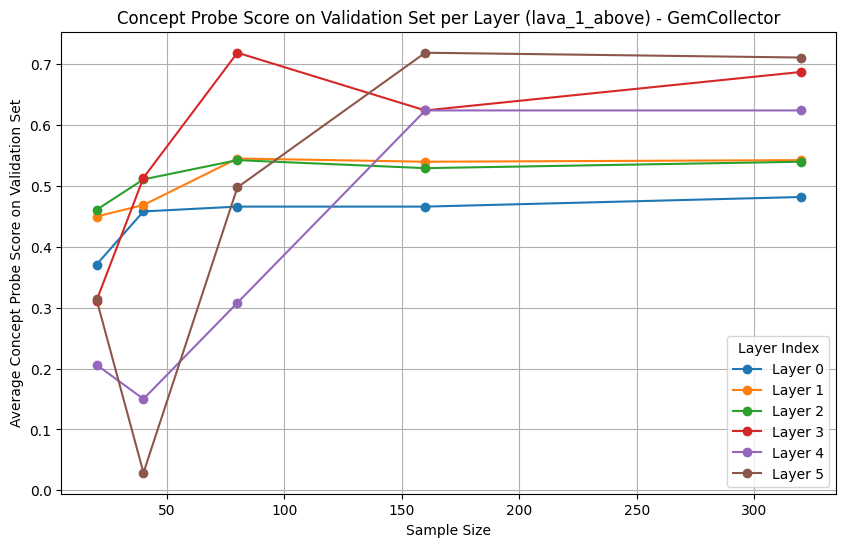

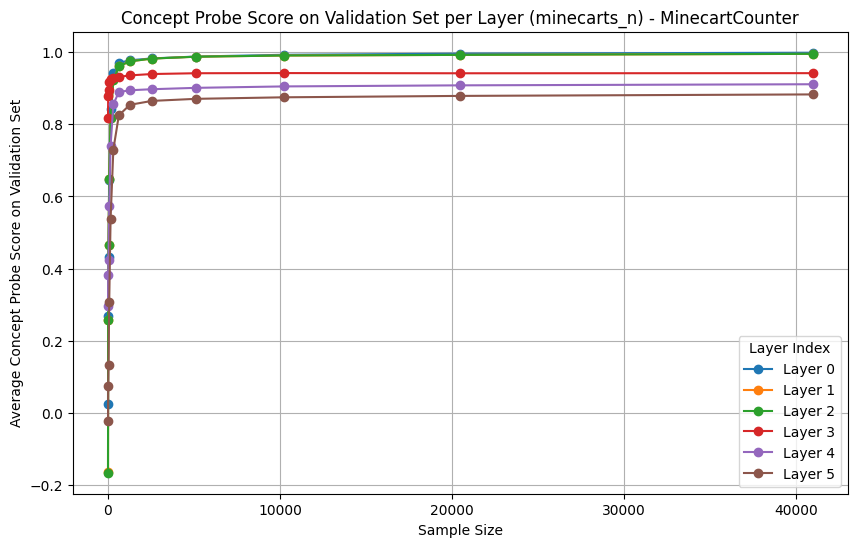

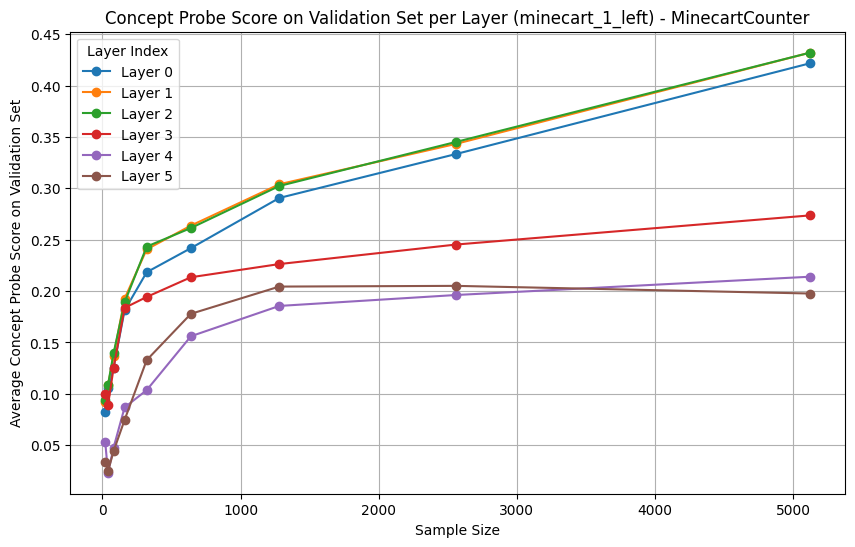

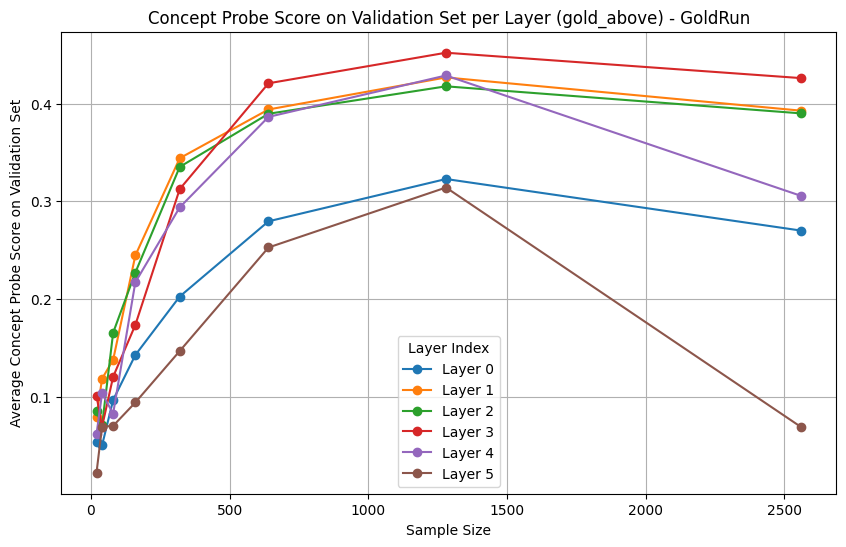

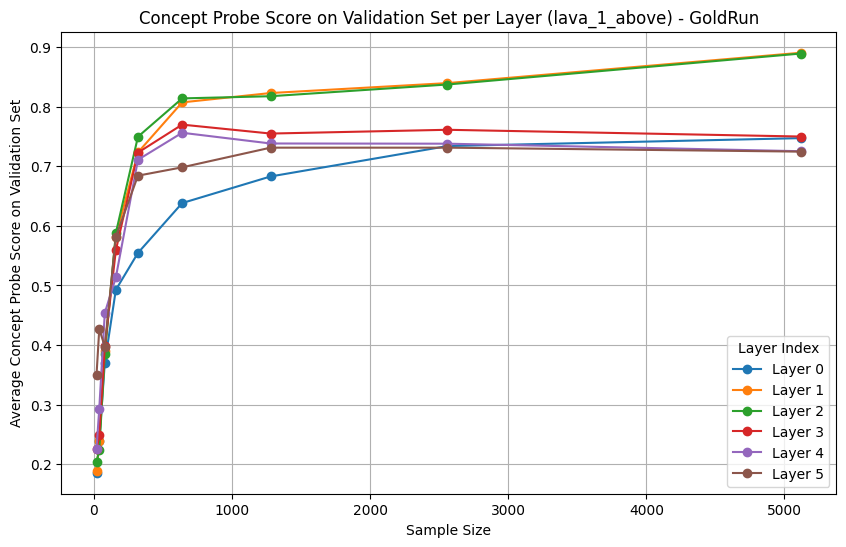

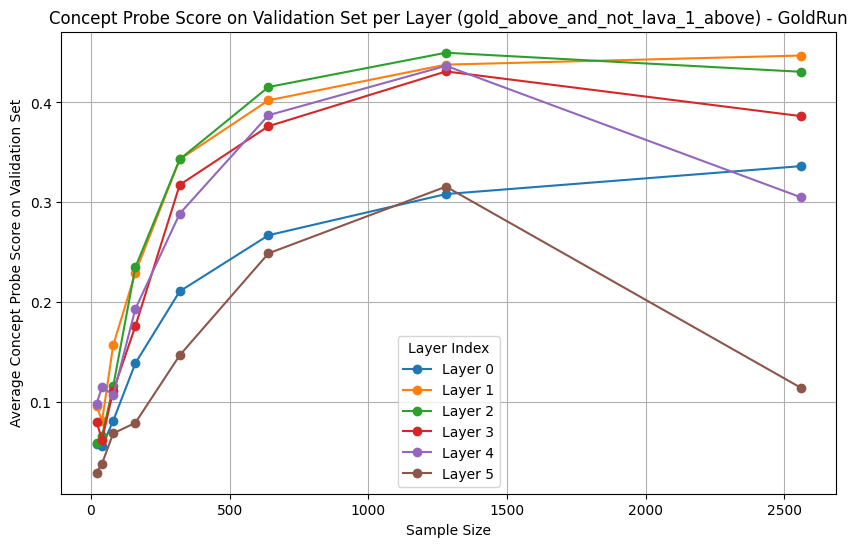

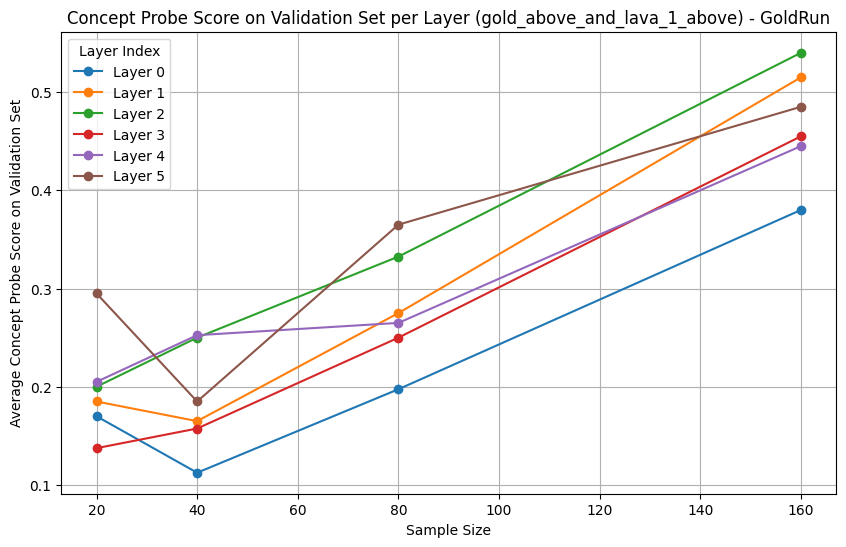

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_concept_probe_scores_per_layer(cps_dfs, env_name, use_log=False):

    combined_df = pd.concat(cps_dfs.values(), ignore_index=True)
    
    combined_df["sample_size"] = combined_df["sample_size"].astype(int)

    unique_concepts = combined_df["concept_name"].unique()

    for concept in unique_concepts:
        plt.figure(figsize=(10, 6))

        concept_df = combined_df[combined_df["concept_name"] == concept]

        unique_layers = concept_df["layer_index"].unique()

        for layer in sorted(unique_layers):
            layer_df = concept_df[concept_df["layer_index"] == layer]

            mean_scores = (
                layer_df.groupby("sample_size")["concept_probe_score_on_validation_set"]
                .mean()
                .reset_index()
            )

            plt.plot(
                mean_scores["sample_size"],
                mean_scores["concept_probe_score_on_validation_set"],
                marker="o",
                linestyle="-",
                label=f"Layer {layer}"
            )

        plt.xlabel("Sample Size")
        plt.ylabel("Average Concept Probe Score on Validation Set")
        plt.title(f"Concept Probe Score on Validation Set per Layer ({concept}) - {env_name}")
        plt.legend(title="Layer Index")
        plt.grid(True)

        if use_log:
            plt.xscale("log")  

        plt.show()

plot_concept_probe_scores_per_layer(gc_cps_dfs, "GemCollector")
plot_concept_probe_scores_per_layer(mc_cps_dfs, "MinecartCounter")
plot_concept_probe_scores_per_layer(grm_cps_dfs, "GoldRun")